In [1]:
import time
import numpy as np
from setup_pybullet import Simulation
from tools import getcubeplacement, setupwithmeshcat
import pinocchio as pin

from control_utils import *
from trajectory_optimizer import TrajectoryOptimizer
        
from tools import setupwithpybulletandmeshcat, rununtil
from config import DT

robot, cube, viz = setupwithmeshcat()

from config import CUBE_PLACEMENT, CUBE_PLACEMENT_TARGET    
from inverse_geometry import computeqgrasppose
from path import computepathwithcubepos, displaypath

q0,successinit = computeqgrasppose(robot, robot.q0, cube, CUBE_PLACEMENT, None)
qe,successend = computeqgrasppose(robot, robot.q0, cube, CUBE_PLACEMENT_TARGET,  None)
path = computepathwithcubepos(q0, qe, CUBE_PLACEMENT, CUBE_PLACEMENT_TARGET, robot, cube, viz)
cube_waypoints, pose_waypoints = zip(*path)

robot, sim, cube, viz = setupwithpybulletandmeshcat()

tcur = 0.
total_time = 3.

pq, pqn = create_optimized_bezier_trajectory_b(robot, cube, viz, pose_waypoints,
                                            total_time=total_time, 
                                            ramp_time=0.5, 
                                            n_bezier_control_points=10, 
                                            n_bezier_cost_samples=50)

   

pybullet build time: Oct 14 2023 16:04:51


Wrapper tries to connect to server <tcp://127.0.0.1:6000>
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
🦾 Starting RTT*
✅ Exploring search space: Path found!          
✅ Local path optimization: Done! Path length reduced by: 18%            
Wrapper tries to connect to server <tcp://127.0.0.1:6000>
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Version = 4.1 Metal - 83
Vendor = Apple
Renderer = Apple M1 Pro
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
b3Printf: b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:

b3Printf: No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frame
b3Printf: b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:

b3Printf: base_link
[Simulation] Found 19 DOFs
b3Printf: b3Warning[examples/Importers

In [26]:
from trajectory_plots import trajectory_analysis


def create_path_comparison_b(pose_waypoints, cube_waypoints, pqn, pq, total_time=3, ramp_time=0.5, evaluation_samples=1000):

    # Linear trajectory
    pql_eval = create_linear_trajectory(pose_waypoints, cube_waypoints, total_time=total_time, ramp_time=ramp_time, n_samples=evaluation_samples)

    # Create an array of parameters to iterate through
    t = np.linspace(0, 1, evaluation_samples)

    pqn_eval = np.array([pqn(ti) for ti in t])

    # Evaluate pq at each time step
    pq_eval = np.array([pq(ti * total_time) for ti in t])

    dt = total_time / evaluation_samples

    q0 = pose_waypoints[0]

    return {
        "linear": trajectory_analysis(q0, pql_eval, dt),
        "naive_bezier": trajectory_analysis(q0, pqn_eval, dt),
        "optimized_bezier": trajectory_analysis(q0, pq_eval, dt)
    }

In [27]:
c = create_path_comparison_b(pose_waypoints, cube_waypoints, pqn, pq)

Wrapper tries to connect to server <tcp://127.0.0.1:6000>
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Wrapper tries to connect to server <tcp://127.0.0.1:6000>
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Wrapper tries to connect to server <tcp://127.0.0.1:6000>
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


In [28]:
import matplotlib.pyplot as plt
from trajectory_plots import normalize

In [29]:
c["linear"]["cube_trajectory"] # This is a 3d path of shape (n, 3)
x,y,z = (c["linear"]["cube_trajectory"][:,i] for i in range(3))


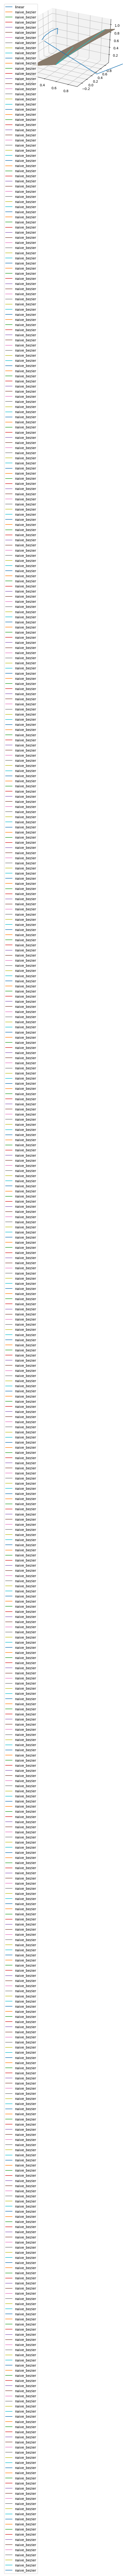

In [30]:
# Plot 3d
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(x,y,z, label="linear")
ax.plot(*normalize(c["naive_bezier"]["cube_trajectory"]), label="naive_bezier")
# ax.plot(*normalize(c["optimized_bezier"]["cube_trajectory"]), label="optimized_bezier")
ax.legend()
plt.show()

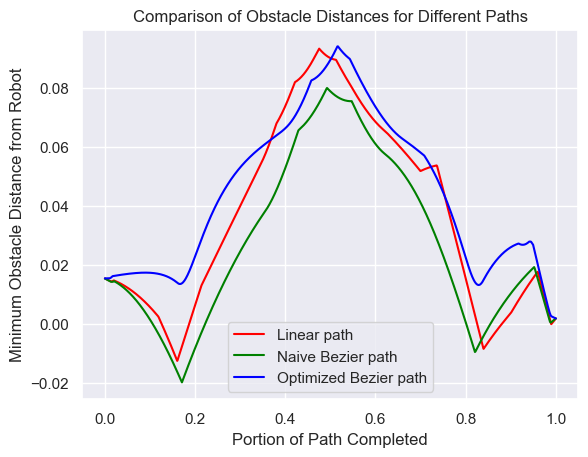

In [49]:
# Plotting
plt.plot(normalize(c["linear"]["cube_distance"]), c["linear"]["obstacle_distances"][1:], label="Linear path", color="red")
plt.plot(normalize(c["naive_bezier"]["cube_distance"]), c["naive_bezier"]["obstacle_distances"][1:], label="Naive Bezier path", color="green")
plt.plot(normalize(c["optimized_bezier"]["cube_distance"]), c["optimized_bezier"]["obstacle_distances"][1:], label="Optimized Bezier path", color="blue")

# Enhancements
plt.title("Comparison of Obstacle Distances for Different Paths")
plt.xlabel("Portion of Path Completed")
plt.ylabel("Minimum Obstacle Distance from Robot")
plt.legend()
plt.grid(True)

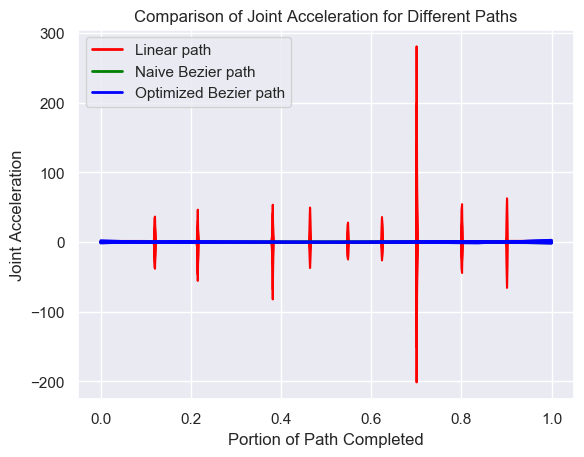

In [51]:
# Plotting without labels
plt.plot(normalize(c["linear"]["cube_distance"][2:]), c["linear"]["joint_acceleration"][1:], color="red")
plt.plot(normalize(c["naive_bezier"]["cube_distance"][2:]), c["naive_bezier"]["joint_acceleration"][1:], color="green")
plt.plot(normalize(c["optimized_bezier"]["cube_distance"][2:]), c["optimized_bezier"]["joint_acceleration"][1:], color="blue")

# Enhancements
plt.title("Comparison of Joint Acceleration for Different Paths")
plt.xlabel("Portion of Path Completed")
plt.ylabel("Joint Acceleration")
plt.grid(True)

# Custom Legend
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color="red", lw=2),
                Line2D([0], [0], color="green", lw=2),
                Line2D([0], [0], color="blue", lw=2)]
plt.legend(custom_lines, ['Linear path', 'Naive Bezier path', 'Optimized Bezier path'])

# Display the plot
plt.show()


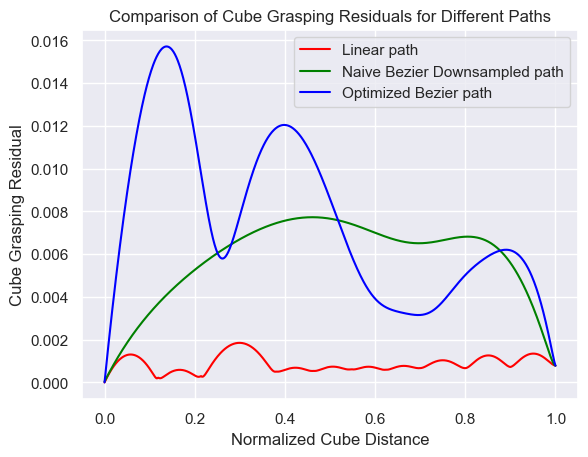

: 

In [59]:
# Plotting
plt.plot(normalize(c["linear"]["cube_distance"]), c["linear"]["cube_grasping_residual"][1:], label="Linear path", color="red")
plt.plot(normalize(c["naive_bezier"]["cube_distance"]), c["naive_bezier"]["cube_grasping_residual"][1:], label="Naive Bezier Downsampled path", color="green")
plt.plot(normalize(c["optimized_bezier"]["cube_distance"]), c["optimized_bezier"]["cube_grasping_residual"][1:], label="Optimized Bezier path", color="blue")

# Enhancements
plt.title("Comparison of Cube Grasping Residuals for Different Paths")
plt.xlabel("Normalized Cube Distance")
plt.ylabel("Cube Grasping Residual")
plt.legend()
plt.grid(True)

# Display the plot
plt.show()